In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install rasterio

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 91.7 MB/s eta 0:00:00


In [ ]:
# Replace with your actual Drive paths
cloudy_zip = "/content/drive/MyDrive/cloud/sentinel2_raw_tifs.zip"
clear_zip = "/content/drive/MyDrive/cloud/sentinel2_nocloud_tifs.zip"


In [ ]:
import zipfile

with zipfile.ZipFile(cloudy_zip) as zf:
    print("Cloudy ZIP contains:", [f for f in zf.namelist() if f.endswith('.tif')])

with zipfile.ZipFile(clear_zip) as zf:
    print("Non-cloudy ZIP contains:", [f for f in zf.namelist() if f.endswith('.tif')])


Cloudy ZIP contains: ['masked_rgb_4.tif', 'masked_rgb_2.tif', 'masked_rgb_1.tif', 'masked_rgb_3.tif', 'masked_rgb_5.tif']
Non-cloudy ZIP contains: ['masked_rgb_5.tif', 'masked_rgb_3.tif', 'masked_rgb_1.tif', 'masked_rgb_2.tif', 'masked_rgb_4.tif']


In [ ]:

from io import BytesIO
import rasterio
import matplotlib.pyplot as plt
import numpy as np

with zipfile.ZipFile(cloudy_zip) as zf:
    tif_files = [f for f in zf.namelist() if f.endswith('.tif')]
    with zf.open(tif_files[0]) as f:
        with rasterio.open(BytesIO(f.read())) as src:
            rgb = src.read([1,2,3]).astype(np.float32)

            # Replace NaNs with 0
            rgb = np.nan_to_num(rgb, nan=0.0)

            # Normalize for display
            rgb_vis = rgb / np.nanmax(rgb)
            rgb_vis = np.transpose(rgb_vis, (1,2,0))

            import matplotlib.pyplot as plt
            plt.figure(figsize=(6,6))
            plt.imshow(rgb_vis)
            plt.axis("off")
            plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 73.7 MB/s eta 0:00:00


NameError: name 'zipfile' is not defined

In [ ]:
import zipfile
from io import BytesIO
import rasterio
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
class CloudPatchDataset(Dataset):
    def __init__(self, cloudy_zip_path, clear_zip_path, patch_size=128, patches_per_image=50):
        """
        Args:
            cloudy_zip_path: Path to ZIP with cloudy TIFFs
            clear_zip_path: Path to ZIP with non-cloudy TIFFs
            patch_size: size of square patches
            patches_per_image: number of random patches to extract per image
        """
        self.cloudy_zip_path = cloudy_zip_path
        self.clear_zip_path = clear_zip_path
        self.patch_size = patch_size
        self.patches_per_image = patches_per_image

        # List TIFF files in ZIPs
        with zipfile.ZipFile(cloudy_zip_path) as zf:
            self.cloudy_files = [f for f in zf.namelist() if f.endswith('.tif')]
        with zipfile.ZipFile(clear_zip_path) as zf:
            self.clear_files = [f for f in zf.namelist() if f.endswith('.tif')]

        assert len(self.cloudy_files) == len(self.clear_files), "Mismatch in number of files"

    def __len__(self):
        return len(self.cloudy_files) * self.patches_per_image

    def __getitem__(self, idx):
        # Determine which image
        image_idx = idx // self.patches_per_image
        with zipfile.ZipFile(self.cloudy_zip_path) as zf_c, zipfile.ZipFile(self.clear_zip_path) as zf_nc:
            cloudy_file = self.cloudy_files[image_idx]
            clear_file = self.clear_files[image_idx]

            with zf_c.open(cloudy_file) as f_c, zf_nc.open(clear_file) as f_nc:
                with rasterio.open(BytesIO(f_c.read())) as src_c, rasterio.open(BytesIO(f_nc.read())) as src_nc:
                    H, W = src_c.height, src_c.width

                    # Random crop coordinates
                    i = np.random.randint(0, H - self.patch_size)
                    j = np.random.randint(0, W - self.patch_size)
                    window = rasterio.windows.Window(j, i, self.patch_size, self.patch_size)

                    # Read RGB bands (1,2,3)
                    cloudy_patch = src_c.read([1,2,3], window=window).astype(np.float32)
                    clear_patch = src_nc.read([1,2,3], window=window).astype(np.float32)

                    # Handle NaNs (cloudy pixels)
                    cloud_mask = np.isnan(cloudy_patch[0]).astype(np.float32)  # 1=cloud, 0=clear
                    cloud_mask = np.expand_dims(cloud_mask, axis=0)
                    cloudy_patch = np.nan_to_num(cloudy_patch, nan=0.0)

                    # Normalize Sentinel-2 RGB (~0-10000) to 0-1
                    cloudy_patch /= 10000.0
                    clear_patch /= 10000.0

                    # To torch tensors
                    x = torch.tensor(cloudy_patch, dtype=torch.float32)
                    y = torch.tensor(clear_patch, dtype=torch.float32)
                    mask = torch.tensor(cloud_mask, dtype=torch.float32)

                    return x, y, mask


In [ ]:
cloudy_zip = "/content/drive/MyDrive/cloud/sentinel2_raw_tifs.zip"
clear_zip = "/content/drive/MyDrive/cloud/sentinel2_nocloud_tifs.zip"

dataset = CloudPatchDataset(cloudy_zip, clear_zip, patch_size=64, patches_per_image=50)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check one patch
x, y, mask = next(iter(loader))
print("Cloudy patch shape:", x.shape)
print("Clear patch shape:", y.shape)
print("Mask shape:", mask.shape)


Cloudy patch shape: torch.Size([4, 3, 64, 64])
Clear patch shape: torch.Size([4, 3, 64, 64])
Mask shape: torch.Size([4, 1, 64, 64])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec1 = nn.Conv2d(64, 3, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Encoder
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))

        # Decoder
        d3 = self.relu(self.dec3(self.up(e3)))
        d2 = self.relu(self.dec2(self.up(d3)))
        out = self.dec1(d2)
        return out


In [ ]:
def masked_mse(pred, target, mask):
    # mask: 1 = cloud pixel, 0 = clear
    diff = (pred - target) ** 2
    masked_diff = diff * mask
    return masked_diff.sum() / (mask.sum() + 1e-8)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # smaller LR to avoid explosions
criterion = nn.MSELoss()

num_epochs = 10
loader = DataLoader(dataset, batch_size=8, shuffle=True)  # try smaller batch first

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x, y, mask in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)

        loss = criterion(out, y)   # <--- simple MSE
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # prevent NaNs
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")


Using device: cuda


KeyboardInterrupt: 

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", device)

# model = SimpleCNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# num_epochs = 10
# loader = DataLoader(dataset, batch_size=16, shuffle=True)  # your PatchTensorDataset

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for x, y, mask in loader:
#         x, y, mask = x.to(device), y.to(device), mask.to(device)
#         optimizer.zero_grad()
#         out = model(x)
#         loss = masked_mse(out, y, mask)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")


Using device: cuda
Epoch 1/10, Loss: nan
Epoch 2/10, Loss: nan


KeyboardInterrupt: 

**downscaling of images**

In [ ]:
# =========================
# Preprocessing Sentinel-2 patches
# =========================
import numpy as np
import torch
import rasterio
import zipfile
from io import BytesIO

def preprocess_patches(cloudy_zip, clear_zip, patch_size=128, patches_per_image=50, out_file="/content/dataset.pt"):
    data_x, data_y, data_mask = [], [], []

    with zipfile.ZipFile(cloudy_zip) as zc, zipfile.ZipFile(clear_zip) as zn:
        cloudy_files = [f for f in zc.namelist() if f.endswith(".tif")]
        clear_files  = [f for f in zn.namelist() if f.endswith(".tif")]

        assert len(cloudy_files) == len(clear_files), "Mismatch in number of TIFF files"

        for cf, nf in zip(cloudy_files, clear_files):
            with zc.open(cf) as f_c, zn.open(nf) as f_n:
                with rasterio.open(BytesIO(f_c.read())) as src_c, rasterio.open(BytesIO(f_n.read())) as src_n:
                    H, W = src_c.height, src_c.width

                    for _ in range(patches_per_image):
                        # Random patch coordinates
                        i = np.random.randint(0, H - patch_size)
                        j = np.random.randint(0, W - patch_size)
                        window = rasterio.windows.Window(j, i, patch_size, patch_size)

                        # Read 3 RGB bands
                        cloudy_patch = src_c.read([1,2,3], window=window).astype(np.float32)
                        clear_patch  = src_n.read([1,2,3], window=window).astype(np.float32)

                        # Cloud mask (1 = cloud, 0 = clear)
                        cloud_mask = np.isnan(cloudy_patch[0]).astype(np.float32)
                        cloud_mask = np.expand_dims(cloud_mask, axis=0)

                        # Replace NaNs with 0 in both patches
                        cloudy_patch = np.nan_to_num(cloudy_patch, nan=0.0)
                        clear_patch  = np.nan_to_num(clear_patch, nan=0.0)

                        # Normalize Sentinel-2 RGB to 0-1
                        cloudy_patch /= 10000.0
                        clear_patch  /= 10000.0

                        # Clip to [0,1] to be extra safe
                        cloudy_patch = np.clip(cloudy_patch, 0.0, 1.0)
                        clear_patch  = np.clip(clear_patch, 0.0, 1.0)

                        # Convert to torch tensors
                        data_x.append(torch.tensor(cloudy_patch, dtype=torch.float32))
                        data_y.append(torch.tensor(clear_patch, dtype=torch.float32))
                        data_mask.append(torch.tensor(cloud_mask, dtype=torch.float32))

    # Save preprocessed dataset
    torch.save({
        "x": torch.stack(data_x),
        "y": torch.stack(data_y),
        "mask": torch.stack(data_mask)
    }, out_file)

    print(f"✅ Saved {len(data_x)} patches to {out_file}")


In [ ]:
import numpy as np
import torch
import rasterio
import zipfile
from io import BytesIO

def preprocess_patches(cloudy_zip, clear_zip,
                       patch_size=256, patches_per_image=100,
                       out_file="/content/dataset.pt",
                       min_cloud_fraction=0.01):  # min 1% cloud in cloudy patch

    data_x, data_y, data_mask = [], [], []

    with zipfile.ZipFile(cloudy_zip) as zc, zipfile.ZipFile(clear_zip) as zn:
        cloudy_files = [f for f in zc.namelist() if f.endswith(".tif")]
        clear_files  = [f for f in zn.namelist() if f.endswith(".tif")]

        assert len(cloudy_files) == len(clear_files), "Mismatch in number of TIFF files"

        for cf, nf in zip(cloudy_files, clear_files):
            with zc.open(cf) as f_c, zn.open(nf) as f_n:
                with rasterio.open(BytesIO(f_c.read())) as src_c, rasterio.open(BytesIO(f_n.read())) as src_n:
                    H, W = src_c.height, src_c.width

                    patches_generated = 0
                    attempts = 0
                    while patches_generated < patches_per_image and attempts < patches_per_image * 10:
                        attempts += 1

                        # Random patch coordinates
                        i = np.random.randint(0, H - patch_size)
                        j = np.random.randint(0, W - patch_size)
                        window = rasterio.windows.Window(j, i, patch_size, patch_size)

                        # Read RGB bands
                        cloudy_patch = src_c.read([1, 2, 3], window=window).astype(np.float32)
                        clear_patch  = src_n.read([1, 2, 3], window=window).astype(np.float32)

                        # Build cloud mask (NaNs in cloudy patch)
                        cloud_mask = np.isnan(cloudy_patch[0]).astype(np.float32)
                        cloud_mask = np.expand_dims(cloud_mask, axis=0)

                        cloud_fraction = cloud_mask.sum() / (patch_size * patch_size)

                        # Skip patch if cloudy patch has no clouds
                        if cloud_fraction < min_cloud_fraction:
                            continue

                        # Skip patch if clear patch has any invalid pixels (NaN or 0 nodata)
                        if np.isnan(clear_patch).any():
                            continue
                        if (clear_patch == 0).any():
                            continue

                        # Replace NaNs in cloudy image with 0
                        cloudy_patch = np.nan_to_num(cloudy_patch, nan=0.0)

                        # Normalize to [0,1]
                        cloudy_patch /= 10000.0
                        clear_patch  /= 10000.0

                        cloudy_patch = np.clip(cloudy_patch, 0.0, 1.0)
                        clear_patch  = np.clip(clear_patch, 0.0, 1.0)

                        # Save valid patch
                        data_x.append(torch.tensor(cloudy_patch, dtype=torch.float32))
                        data_y.append(torch.tensor(clear_patch, dtype=torch.float32))
                        data_mask.append(torch.tensor(cloud_mask, dtype=torch.float32))

                        patches_generated += 1

    # Save dataset
    torch.save({
        "x": torch.stack(data_x),
        "y": torch.stack(data_y),
        "mask": torch.stack(data_mask)
    }, out_file)

    print(f"✅ Saved {len(data_x)} patches to {out_file}")


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
# Step 1: Preprocess and save patches
preprocess_patches(
    cloudy_zip="/content/drive/MyDrive/cloud/sentinel2_raw_tifs.zip",
    clear_zip="/content/drive/MyDrive/cloud/sentinel2_nocloud_tifs.zip",
    patch_size=224,
    patches_per_image=20,
    out_file="/content/dataset.pt"
)

# Step 2: Load preprocessed patches
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

# Step 3: Check one batch (instant)
x_batch, y_batch, mask_batch = next(iter(loader))
print(x_batch.shape, y_batch.shape, mask_batch.shape)


✅ Saved 93 patches to /content/dataset.pt
torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])


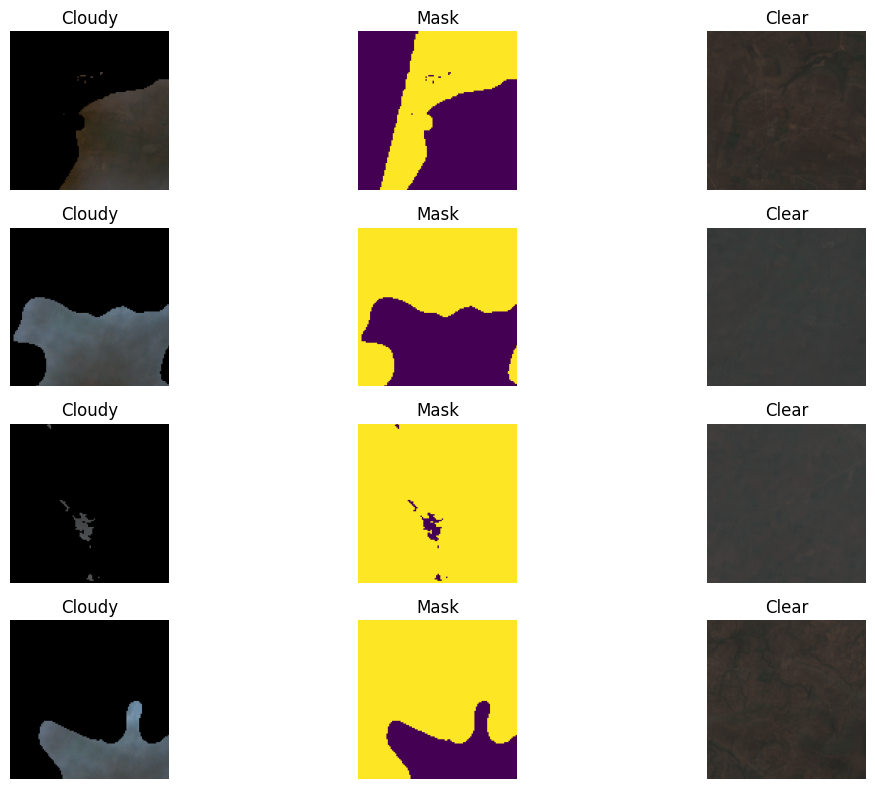

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Take first batch
x_batch, y_batch, mask_batch = next(iter(loader))

# Select first 4 patches
num_patches = 4

plt.figure(figsize=(12, 8))
for i in range(num_patches):
    # Cloudy patch
    plt.subplot(num_patches, 3, i*3 + 1)
    plt.imshow(np.transpose(x_batch[i].numpy(), (1,2,0)))  # C,H,W -> H,W,C
    plt.title("Cloudy")
    plt.axis("off")

    # Mask patch
    plt.subplot(num_patches, 3, i*3 + 2)
    plt.imshow(np.transpose(mask_batch[i].numpy(), (1,2,0)))
    plt.title("Mask")
    plt.axis("off")

    # Clear patch
    plt.subplot(num_patches, 3, i*3 + 3)
    plt.imshow(np.transpose(y_batch[i].numpy(), (1,2,0)))
    plt.title("Clear")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Optional simple augmentation function
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)
    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ Model Definition
# =========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Smaller CNN for stability on small dataset
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec1 = nn.Conv2d(32, 3, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))
        d3 = self.relu(self.dec3(self.up(e3)))
        d2 = self.relu(self.dec2(self.up(d3)))
        out = self.dec1(d2)
        return out

model = SimpleCNN().to(device)

# =========================
# 4️⃣ Masked MSE Loss (NaN-safe + gradient-safe)
# =========================
def masked_mse(pred, target, mask):
    valid = (1 - mask)
    denom = valid.sum()
    if denom < 1:
        # Ensure tensor tracks gradient
        return torch.tensor(0.0, device=pred.device, dtype=pred.dtype, requires_grad=True)
    diff = (pred - target)**2 * valid
    return diff.sum() / denom

# =========================
# 5️⃣ Optimizer & Training
# =========================
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)
        loss = masked_mse(out, y_batch, mask_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")

# =========================
# 6️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/simple_cnn_cloud.pth")
print("✅ Model saved!")


Using device: cuda
Epoch 1/10, Loss: 0.069585
Epoch 2/10, Loss: 0.031639
Epoch 3/10, Loss: 0.004583
Epoch 4/10, Loss: 0.003472
Epoch 5/10, Loss: 0.003028
Epoch 6/10, Loss: 0.003263
Epoch 7/10, Loss: 0.003243
Epoch 8/10, Loss: 0.003118
Epoch 9/10, Loss: 0.003424
Epoch 10/10, Loss: 0.003097
✅ Model saved!


In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Optional simple augmentation function
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)
    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ Model Definition
# =========================
class SimpleCNNRef(nn.Module):
    def __init__(self):
        super(SimpleCNNRef, self).__init__()
        # Main encoder
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)

        # Reference encoder (can share weights if needed)
        self.ref_enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.ref_enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.ref_enc3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Decoder
        # Input channels = main encoder + reference features
        self.dec3 = nn.Conv2d(128*2, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64*2, 32, 3, padding=1)
        self.dec1 = nn.Conv2d(32, 3, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x, ref):
        # Encode main image
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))

        # Encode reference image
        r1 = self.relu(self.ref_enc1(ref))
        r2 = self.relu(self.ref_enc2(self.pool(r1)))
        r3 = self.relu(self.ref_enc3(self.pool(r2)))

        # Decode with concatenated features
        d3 = self.relu(self.dec3(self.up(torch.cat([e3, r3], dim=1))))
        d2 = self.relu(self.dec2(self.up(torch.cat([d3, r2], dim=1))))
        out = self.dec1(d2)
        return out

model = SimpleCNN().to(device)

# =========================
# 4️⃣ Masked MSE Loss (NaN-safe + gradient-safe)
# =========================
def masked_mse(pred, target, mask):
    valid = (1 - mask)
    denom = valid.sum()
    if denom < 1:
        # Ensure tensor tracks gradient
        return torch.tensor(0.0, device=pred.device, dtype=pred.dtype, requires_grad=True)
    diff = (pred - target)**2 * valid
    return diff.sum() / denom

# =========================
# 5️⃣ Optimizer & Training
# =========================
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)
        loss = masked_mse(out, y_batch, mask_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")

# =========================
# 6️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/simple_cnn_cloud.pth")
print("✅ Model saved!")


Using device: cuda
Epoch 1/10, Loss: 0.167634
Epoch 2/10, Loss: 0.080161
Epoch 3/10, Loss: 0.013705
Epoch 4/10, Loss: 0.007116
Epoch 5/10, Loss: 0.005520
Epoch 6/10, Loss: 0.005702
Epoch 7/10, Loss: 0.004453
Epoch 8/10, Loss: 0.004142
Epoch 9/10, Loss: 0.003709
Epoch 10/10, Loss: 0.004173
✅ Model saved!


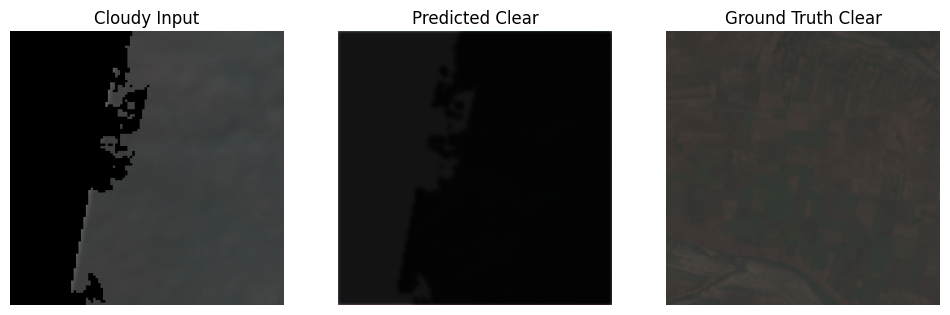

In [ ]:
import matplotlib.pyplot as plt

# Set model to evaluation
model.eval()

# Get a batch from DataLoader
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

# Predict
with torch.no_grad():
    pred = model(x_batch)

# Visualize the first patch
plt.figure(figsize=(12,4))

# Cloudy input
plt.subplot(1,3,1)
plt.title("Cloudy Input")
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.axis('off')

# Model prediction
plt.subplot(1,3,2)
plt.title("Predicted Clear")
plt.imshow(pred[0].cpu().permute(1,2,0))
plt.axis('off')

# Ground truth
plt.subplot(1,3,3)
plt.title("Ground Truth Clear")
plt.imshow(y_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.show()


In [ ]:
print("x NaNs:", torch.isnan(x).any())
print("y NaNs:", torch.isnan(y).any())
print("mask NaNs:", torch.isnan(mask).any())

print("x max/min:", x.max().item(), x.min().item())
print("y max/min:", y.max().item(), y.min().item())


x NaNs: tensor(False)
y NaNs: tensor(True)
mask NaNs: tensor(False)
x max/min: 0.670799970626831 0.0
y max/min: nan nan


In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Optional simple augmentation function
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)
    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ Model Definition (Fixed U-Net)
# =========================
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(),
                                  nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                  nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
                                  nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Sequential(nn.Conv2d(128+64, 64, 3, padding=1), nn.ReLU(),
                                  nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(nn.Conv2d(64+32, 32, 3, padding=1), nn.ReLU(),
                                  nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        # Decoder
        d3 = self.dec3(torch.cat([self.up3(e3), e2], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e1], dim=1))
        out = self.final(d2)
        return out

model = UNet().to(device)

# =========================
# 4️⃣ Masked MSE Loss
# =========================
def masked_mse(pred, target, mask):
    valid = (1 - mask)
    denom = valid.sum()
    if denom < 1:
        # Ensure tensor tracks gradient
        return torch.tensor(0.0, device=pred.device, dtype=pred.dtype, requires_grad=True)
    diff = (pred - target)**2 * valid
    return diff.sum() / denom

# =========================
# 5️⃣ Optimizer & Training
# =========================
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)
        loss = masked_mse(out, y_batch, mask_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")

# =========================
# 6️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/unet_cloud.pth")
print("✅ Model saved!")


Using device: cuda
Epoch 1/10, Loss: 0.102715
Epoch 2/10, Loss: 0.079176
Epoch 3/10, Loss: 0.043370
Epoch 4/10, Loss: 0.031598
Epoch 5/10, Loss: 0.030460
Epoch 6/10, Loss: 0.033430
Epoch 7/10, Loss: 0.029646
Epoch 8/10, Loss: 0.029502
Epoch 9/10, Loss: 0.030361
Epoch 10/10, Loss: 0.030056
✅ Model saved!


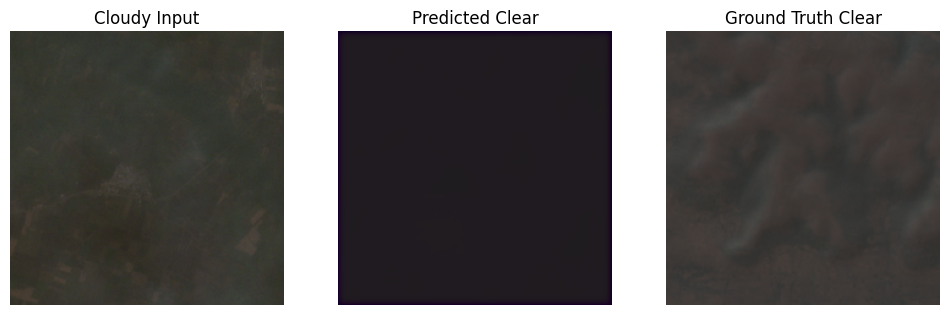

In [ ]:
import matplotlib.pyplot as plt

# Set model to evaluation
model.eval()

# Get a batch from DataLoader
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

# Predict
with torch.no_grad():
    pred = model(x_batch)

# Visualize the first patch
plt.figure(figsize=(12,4))

# Cloudy input
plt.subplot(1,3,1)
plt.title("Cloudy Input")
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.axis('off')

# Model prediction
plt.subplot(1,3,2)
plt.title("Predicted Clear")
plt.imshow(pred[0].cpu().permute(1,2,0))
plt.axis('off')

# Ground truth
plt.subplot(1,3,3)
plt.title("Ground Truth Clear")
plt.imshow(y_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.show()


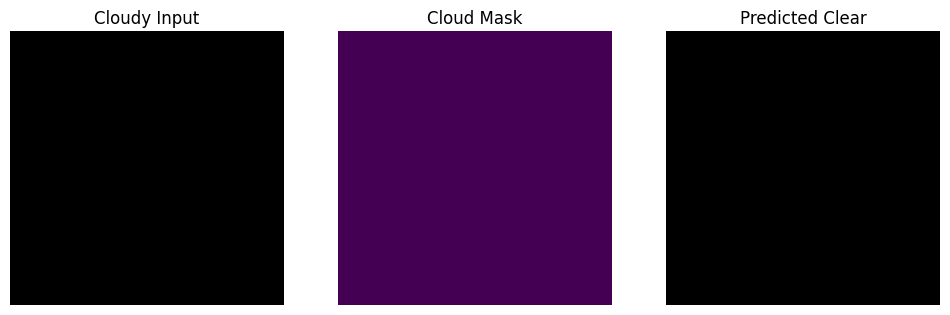

In [ ]:
import matplotlib.pyplot as plt

model.eval()
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)

with torch.no_grad():
    pred = model(x_batch)
    filled = x_batch * (1 - mask_batch) + pred * mask_batch

# Convert first patch to numpy for plotting
inp = x_batch[0].cpu().permute(1,2,0)
mask_patch = mask_batch[0].cpu().permute(1,2,0)
out_patch = filled[0].cpu().permute(1,2,0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(inp); plt.title("Cloudy Input"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mask_patch[:,:,0]); plt.title("Cloud Mask"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(out_patch); plt.title("Predicted Clear"); plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import torch
import rasterio
import zipfile
from io import BytesIO

def preprocess_patches(cloudy_zip, clear_zip,
                       patch_size=256, patches_per_image=100,
                       out_file="/content/dataset.pt",
                       min_cloud_fraction=0.01):  # min 1% cloud in cloudy patch

    data_x, data_y, data_mask = [], [], []

    with zipfile.ZipFile(cloudy_zip) as zc, zipfile.ZipFile(clear_zip) as zn:
        cloudy_files = [f for f in zc.namelist() if f.endswith(".tif")]
        clear_files  = [f for f in zn.namelist() if f.endswith(".tif")]

        assert len(cloudy_files) == len(clear_files), "Mismatch in number of TIFF files"

        for cf, nf in zip(cloudy_files, clear_files):
            with zc.open(cf) as f_c, zn.open(nf) as f_n:
                with rasterio.open(BytesIO(f_c.read())) as src_c, rasterio.open(BytesIO(f_n.read())) as src_n:
                    H, W = src_c.height, src_c.width

                    patches_generated = 0
                    attempts = 0
                    while patches_generated < patches_per_image and attempts < patches_per_image * 10:
                        attempts += 1

                        # Random patch coordinates
                        i = np.random.randint(0, H - patch_size)
                        j = np.random.randint(0, W - patch_size)
                        window = rasterio.windows.Window(j, i, patch_size, patch_size)

                        # Read RGB bands
                        cloudy_patch = src_c.read([1,2,3], window=window).astype(np.float32)
                        clear_patch  = src_n.read([1,2,3], window=window).astype(np.float32)

                        # Cloud mask from cloudy patch
                        cloud_mask = np.isnan(cloudy_patch[0]).astype(np.float32)
                        cloud_mask = np.expand_dims(cloud_mask, axis=0)

                        cloud_fraction = cloud_mask.sum() / (patch_size*patch_size)

                        # Skip patch if cloudy patch has no clouds
                        if cloud_fraction < min_cloud_fraction:
                            continue

                        # Skip patch if clear patch has any clouds
                        if np.isnan(clear_patch[0]).sum() > 0:
                            continue

                        # Replace NaNs in cloudy image with 0
                        cloudy_patch = np.nan_to_num(cloudy_patch, nan=0.0)
                        clear_patch  = np.nan_to_num(clear_patch, nan=0.0)

                        # Normalize RGB to 0-1
                        cloudy_patch /= 10000.0
                        clear_patch  /= 10000.0

                        # Clip to [0,1]
                        cloudy_patch = np.clip(cloudy_patch, 0.0, 1.0)
                        clear_patch  = np.clip(clear_patch, 0.0, 1.0)

                        # Save valid patch
                        data_x.append(torch.tensor(cloudy_patch, dtype=torch.float32))
                        data_y.append(torch.tensor(clear_patch, dtype=torch.float32))
                        data_mask.append(torch.tensor(cloud_mask, dtype=torch.float32))

                        patches_generated += 1

    # Save all patches
    torch.save({
        "x": torch.stack(data_x),
        "y": torch.stack(data_y),
        "mask": torch.stack(data_mask)
    }, out_file)

    print(f"✅ Saved {len(data_x)} patches to {out_file}")


In [ ]:
import numpy as np
import torch
import rasterio
import zipfile
from io import BytesIO

def preprocess_patches(cloudy_zip, clear_zip,
                       patch_size=256, patches_per_image=100,
                       out_file="/content/dataset.pt",
                       min_cloud_fraction=0.01):  # min 1% cloud in cloudy patch

    data_x, data_y, data_mask = [], [], []

    with zipfile.ZipFile(cloudy_zip) as zc, zipfile.ZipFile(clear_zip) as zn:
        cloudy_files = [f for f in zc.namelist() if f.endswith(".tif")]
        clear_files  = [f for f in zn.namelist() if f.endswith(".tif")]

        assert len(cloudy_files) == len(clear_files), "Mismatch in number of TIFF files"

        for cf, nf in zip(cloudy_files, clear_files):
            with zc.open(cf) as f_c, zn.open(nf) as f_n:
                with rasterio.open(BytesIO(f_c.read())) as src_c, rasterio.open(BytesIO(f_n.read())) as src_n:
                    H, W = src_c.height, src_c.width

                    patches_generated = 0
                    attempts = 0
                    while patches_generated < patches_per_image and attempts < patches_per_image * 10:
                        attempts += 1

                        # Random patch coordinates
                        i = np.random.randint(0, H - patch_size)
                        j = np.random.randint(0, W - patch_size)
                        window = rasterio.windows.Window(j, i, patch_size, patch_size)

                        # Read RGB bands
                        cloudy_patch = src_c.read([1, 2, 3], window=window).astype(np.float32)
                        clear_patch  = src_n.read([1, 2, 3], window=window).astype(np.float32)

                        # Build cloud mask (NaNs in cloudy patch)
                        cloud_mask = np.isnan(cloudy_patch[0]).astype(np.float32)
                        cloud_mask = np.expand_dims(cloud_mask, axis=0)

                        cloud_fraction = cloud_mask.sum() / (patch_size * patch_size)

                        # Skip patch if cloudy patch has no clouds
                        if cloud_fraction < min_cloud_fraction:
                            continue

                        # Skip patch if clear patch has any invalid pixels (NaN or 0 nodata)
                        if np.isnan(clear_patch).any():
                            continue
                        if (clear_patch == 0).any():
                            continue

                        # Replace NaNs in cloudy image with 0
                        cloudy_patch = np.nan_to_num(cloudy_patch, nan=0.0)

                        # Normalize to [0,1]
                        cloudy_patch /= 10000.0
                        clear_patch  /= 10000.0

                        cloudy_patch = np.clip(cloudy_patch, 0.0, 1.0)
                        clear_patch  = np.clip(clear_patch, 0.0, 1.0)

                        # Save valid patch
                        data_x.append(torch.tensor(cloudy_patch, dtype=torch.float32))
                        data_y.append(torch.tensor(clear_patch, dtype=torch.float32))
                        data_mask.append(torch.tensor(cloud_mask, dtype=torch.float32))

                        patches_generated += 1

    # Save dataset
    torch.save({
        "x": torch.stack(data_x),
        "y": torch.stack(data_y),
        "mask": torch.stack(data_mask)
    }, out_file)

    print(f"✅ Saved {len(data_x)} patches to {out_file}")


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
# Step 1: Preprocess and save patches
preprocess_patches(
    cloudy_zip="/content/drive/MyDrive/cloud/sentinel2_raw_tifs.zip",
    clear_zip="/content/drive/MyDrive/cloud/sentinel2_nocloud_tifs.zip",
    patch_size=224,
    patches_per_image=100,
    out_file="/content/dataset.pt"
)

# Step 2: Load preprocessed patches
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

loader = DataLoader(TensorDataset(x, y, mask), batch_size=50, shuffle=True)

# Step 3: Check one batch (instant)
x_batch, y_batch, mask_batch = next(iter(loader))
print(x_batch.shape, y_batch.shape, mask_batch.shape)


✅ Saved 443 patches to /content/dataset.pt
torch.Size([50, 3, 224, 224]) torch.Size([50, 3, 224, 224]) torch.Size([50, 1, 224, 224])


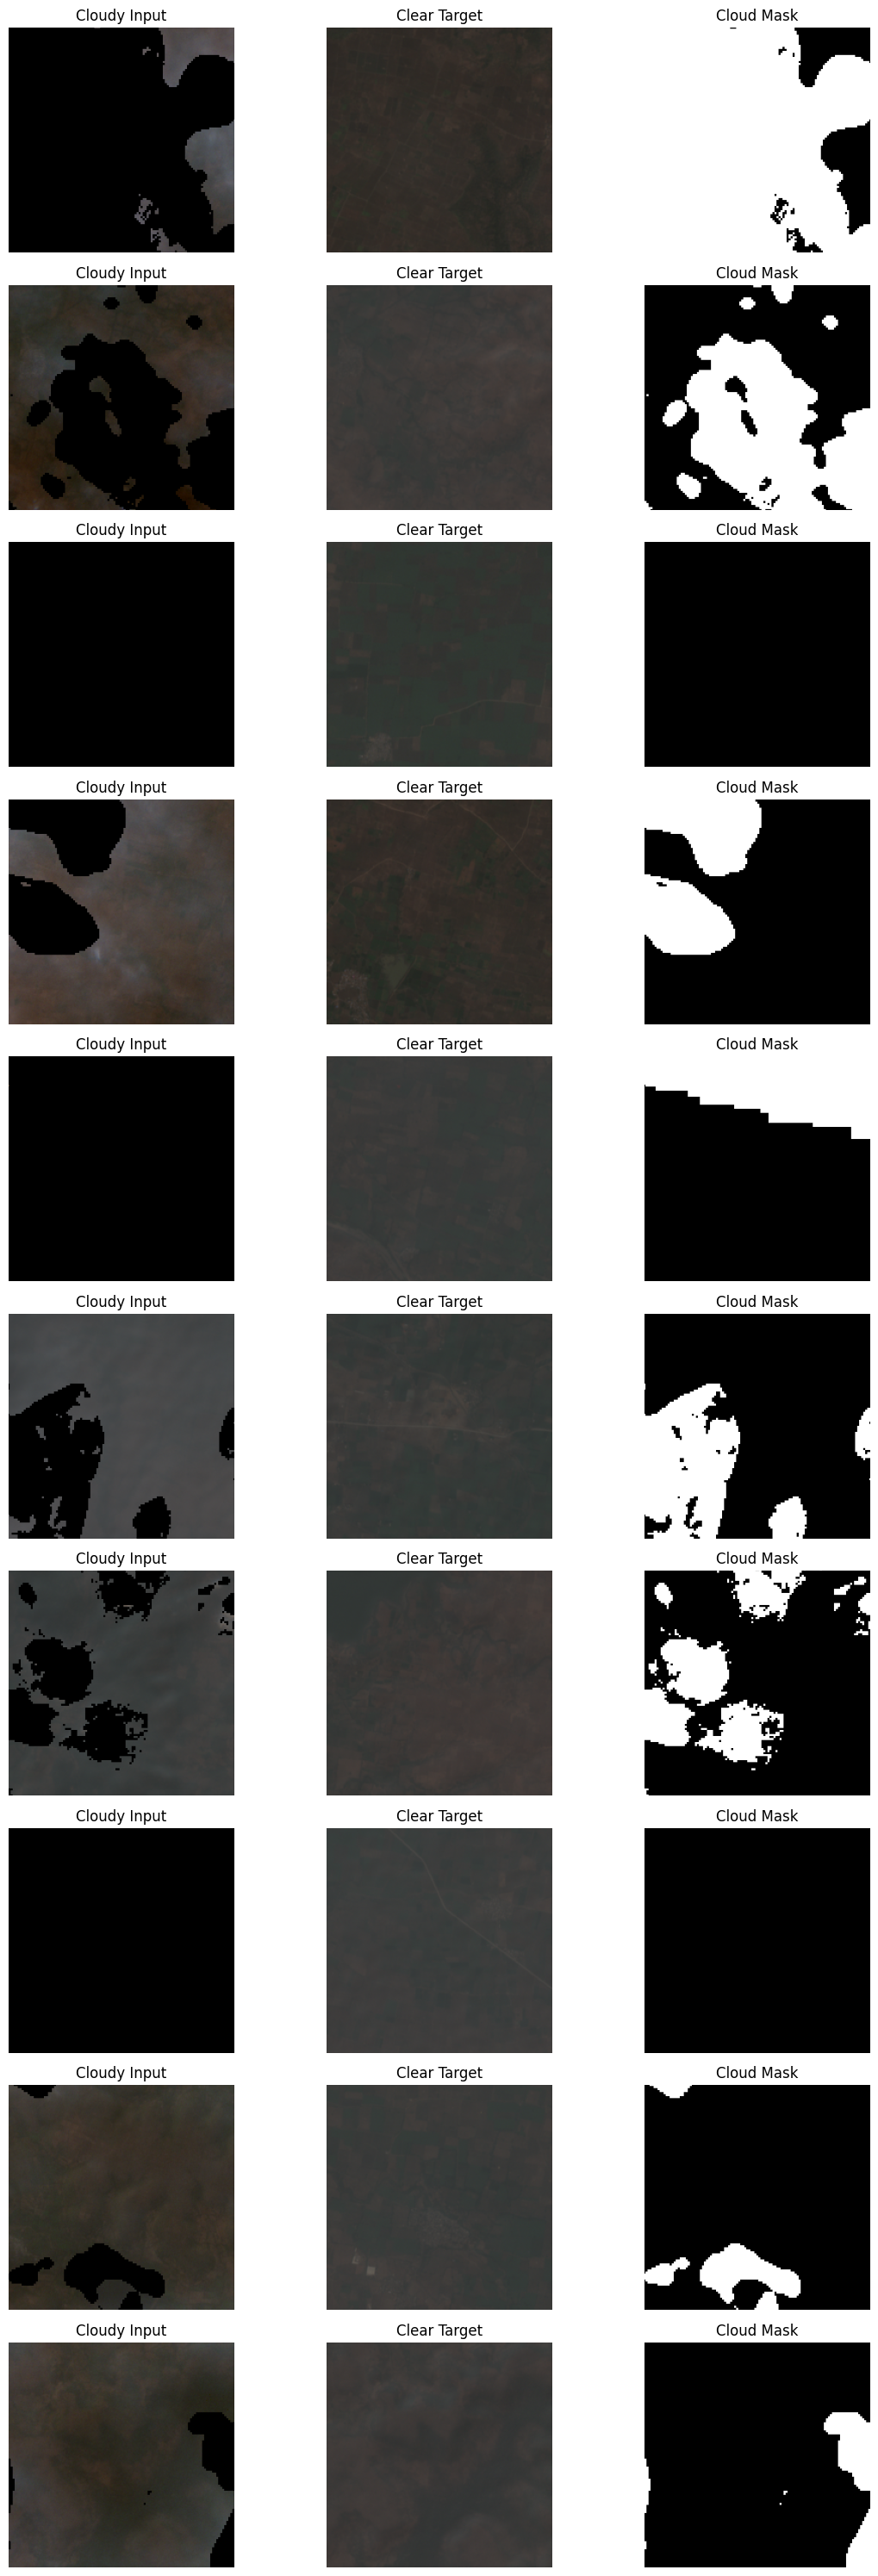

In [ ]:
import matplotlib.pyplot as plt

def show_samples(x, y, mask, n=4):
    """
    Show n samples from batch (cloudy, clear, mask side by side).
    """
    fig, axs = plt.subplots(n, 3, figsize=(12, 3*n))

    for i in range(n):
        cloudy = x[i].permute(1,2,0).numpy()
        clear  = y[i].permute(1,2,0).numpy()
        mask_  = mask[i][0].numpy()

        axs[i,0].imshow(cloudy)
        axs[i,0].set_title("Cloudy Input")
        axs[i,1].imshow(clear)
        axs[i,1].set_title("Clear Target")
        axs[i,2].imshow(mask_, cmap="gray")
        axs[i,2].set_title("Cloud Mask")

        for j in range(3):
            axs[i,j].axis("off")

    plt.tight_layout()
    plt.show()

# Example: show 4 samples from batch
show_samples(x_batch, y_batch, mask_batch, n=10)


In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Optional simple augmentation function
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)
    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ Model Definition
# =========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Smaller CNN for stability on small dataset
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64, 32, 3, padding=1)
        self.dec1 = nn.Conv2d(32, 3, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))
        d3 = self.relu(self.dec3(self.up(e3)))
        d2 = self.relu(self.dec2(self.up(d3)))
        out = self.dec1(d2)
        return out

model = SimpleCNN().to(device)

# =========================
# 4️⃣ Masked MSE Loss (NaN-safe + gradient-safe)
# =========================
def masked_mse(pred, target, mask):
    valid = (1-mask)
    denom = valid.sum()
    if denom < 1:
        # Ensure tensor tracks gradient
        return torch.tensor(0.0, device=pred.device, dtype=pred.dtype, requires_grad=True)
    diff = (pred - target)**2 * valid
    return diff.sum() / denom

# =========================
# 5️⃣ Optimizer & Training
# =========================
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)
        loss = masked_mse(out, y_batch, mask_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")

# =========================
# 6️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/simple_cnn_cloud.pth")
print("✅ Model saved!")


Using device: cuda
Epoch 1/10, Loss: 0.028063
Epoch 2/10, Loss: 0.003962
Epoch 3/10, Loss: 0.003329
Epoch 4/10, Loss: 0.003235
Epoch 5/10, Loss: 0.003232
Epoch 6/10, Loss: 0.003235
Epoch 7/10, Loss: 0.002739
Epoch 8/10, Loss: 0.002748
Epoch 9/10, Loss: 0.002718
Epoch 10/10, Loss: 0.002682
✅ Model saved!


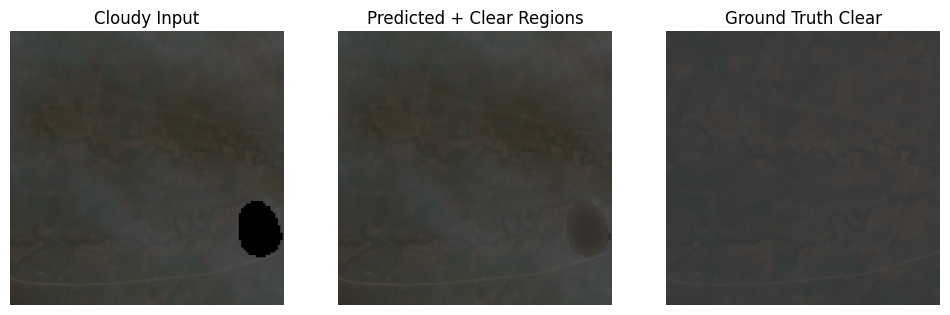

In [ ]:
import matplotlib.pyplot as plt

# Set model to evaluation
model.eval()

# Get a batch from DataLoader
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)

# If mask is single-channel, expand to 3 channels for RGB
if mask_batch.shape[1] == 1:
    mask_batch = mask_batch.repeat(1, 3, 1, 1)

# Predict
with torch.no_grad():
    pred = model(x_batch)

# Combine prediction with original clear regions
pred_full = pred * mask_batch + x_batch * (1 - mask_batch)

# Visualize the first patch
plt.figure(figsize=(12,4))

# Cloudy input
plt.subplot(1,3,1)
plt.title("Cloudy Input")
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.axis('off')

# Model prediction (only cloudy regions replaced)
plt.subplot(1,3,2)
plt.title("Predicted + Clear Regions")
plt.imshow(pred_full[0].cpu().permute(1,2,0))
plt.axis('off')

# Ground truth
plt.subplot(1,3,3)
plt.title("Ground Truth Clear")
plt.imshow(y_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.show()


In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Improved augmentation
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)

    # Small noise
    if random.random() > 0.5:
        batch_x = batch_x + 0.05*torch.randn_like(batch_x)

    # Brightness / contrast
    if random.random() > 0.5:
        batch_x = torch.clamp(batch_x * (0.9 + 0.2*torch.rand_like(batch_x)), 0, 1)

    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ Model Definition with Fixed Residuals
# =========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(256 + 128, 128, 3, padding=1)
        self.dec2 = nn.Conv2d(128 + 64, 64, 3, padding=1)
        self.dec1 = nn.Conv2d(64, 3, 3, padding=1)

        self.relu = nn.ReLU()

    # Residual block with channel projection if needed
    def res_block(self, x, conv, out_channels):
        out = self.relu(conv(x))
        if x.shape[1] != out_channels:
            # project input channels to match output
            x = nn.Conv2d(x.shape[1], out_channels, 1).to(x.device)(x)
        out = out + x
        return out

    def forward(self, x):
        e1 = self.res_block(x, self.enc1, 64)
        e2 = self.res_block(self.pool(e1), self.enc2, 128)
        e3 = self.res_block(self.pool(e2), self.enc3, 256)

        d3 = self.res_block(torch.cat([self.up(e3), e2], dim=1), self.dec3, 128)
        d2 = self.res_block(torch.cat([self.up(d3), e1], dim=1), self.dec2, 64)
        out = self.dec1(d2)
        return out

model = SimpleCNN().to(device)

# =========================
# 4️⃣ Weighted Masked MSE + Smoothness Loss (fixed)
# =========================
def masked_smooth_loss(pred, target, mask):
    # Weighted masked MSE
    weight = mask * 2.0 + 1.0
    mse = ((pred - target)**2 * weight).sum() / weight.sum()

    # Smoothness regularization
    grad_x = (pred[:, :, :, 1:] - pred[:, :, :, :-1])**2
    grad_y = (pred[:, :, 1:, :] - pred[:, :, :-1, :])**2
    smooth_loss = grad_x.mean() + grad_y.mean()

    total_loss = mse + 0.1 * smooth_loss
    return total_loss

# =========================
# 5️⃣ Optimizer & Scheduler
# =========================
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
num_epochs = 30

# =========================
# 6️⃣ Training Loop
# =========================
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)
        loss = masked_smooth_loss(out, y_batch, mask_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

# =========================
# 7️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/simple_cnn_cloud_res_fixed_v2.pth")
print("✅ Model saved!")


Using device: cuda
Epoch 1/30, Loss: 0.038677
Epoch 2/30, Loss: 0.033258
Epoch 3/30, Loss: 0.032991
Epoch 4/30, Loss: 0.025350
Epoch 5/30, Loss: 0.016454
Epoch 6/30, Loss: 0.015984
Epoch 7/30, Loss: 0.013086
Epoch 8/30, Loss: 0.012334
Epoch 9/30, Loss: 0.010054
Epoch 10/30, Loss: 0.009129
Epoch 11/30, Loss: 0.009130
Epoch 12/30, Loss: 0.008949
Epoch 13/30, Loss: 0.006996
Epoch 14/30, Loss: 0.008830
Epoch 15/30, Loss: 0.008093
Epoch 16/30, Loss: 0.007186
Epoch 17/30, Loss: 0.007259
Epoch 18/30, Loss: 0.006282
Epoch 19/30, Loss: 0.006189
Epoch 20/30, Loss: 0.006340
Epoch 21/30, Loss: 0.005537
Epoch 22/30, Loss: 0.005903
Epoch 23/30, Loss: 0.006148
Epoch 24/30, Loss: 0.006212
Epoch 25/30, Loss: 0.004887
Epoch 26/30, Loss: 0.005056
Epoch 27/30, Loss: 0.005424
Epoch 28/30, Loss: 0.005402
Epoch 29/30, Loss: 0.004963
Epoch 30/30, Loss: 0.005070
✅ Model saved!


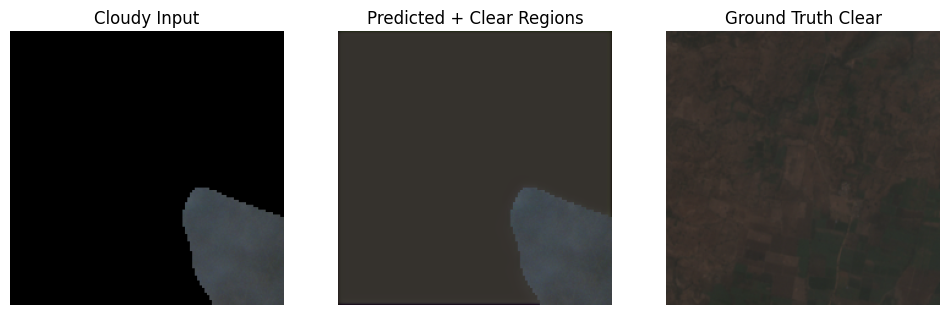

In [ ]:
import matplotlib.pyplot as plt

# Set model to evaluation
model.eval()

# Get a batch from DataLoader
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)

# If mask is single-channel, expand to 3 channels for RGB
if mask_batch.shape[1] == 1:
    mask_batch = mask_batch.repeat(1, 3, 1, 1)

# Predict
with torch.no_grad():
    pred = model(x_batch)

# Combine prediction with original clear regions
pred_full = pred * mask_batch + x_batch * (1 - mask_batch)

# Visualize the first patch
plt.figure(figsize=(12,4))

# Cloudy input
plt.subplot(1,3,1)
plt.title("Cloudy Input")
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.axis('off')

# Model prediction (only cloudy regions replaced)
plt.subplot(1,3,2)
plt.title("Predicted + Clear Regions")
plt.imshow(pred_full[0].cpu().permute(1,2,0))
plt.axis('off')

# Ground truth
plt.subplot(1,3,3)
plt.title("Ground Truth Clear")
plt.imshow(y_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.show()


In [ ]:
# =========================
# 1️⃣ Imports
# =========================
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F

# =========================
# 2️⃣ Load Preprocessed Dataset
# =========================
data = torch.load("/content/dataset.pt")
x, y, mask = data["x"], data["y"], data["mask"]

# Optional simple augmentation function
def augment(batch_x, batch_y, batch_mask):
    if random.random() > 0.5:
        batch_x = batch_x.flip(-1)
        batch_y = batch_y.flip(-1)
        batch_mask = batch_mask.flip(-1)
    if random.random() > 0.5:
        batch_x = batch_x.flip(-2)
        batch_y = batch_y.flip(-2)
        batch_mask = batch_mask.flip(-2)
    return batch_x, batch_y, batch_mask

loader = DataLoader(TensorDataset(x, y, mask), batch_size=4, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# =========================
# 3️⃣ U-Net Model Definition
# =========================
class UNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=32):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.enc2 = nn.Conv2d(base_channels, base_channels*2, 3, padding=1)
        self.enc3 = nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(base_channels*4 + base_channels*2, base_channels*2, 3, padding=1)
        self.dec2 = nn.Conv2d(base_channels*2 + base_channels, base_channels, 3, padding=1)
        self.dec1 = nn.Conv2d(base_channels, in_channels, 3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Encoder
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(self.pool(e1)))
        e3 = self.relu(self.enc3(self.pool(e2)))

        # Decoder
        d3 = self.relu(self.dec3(torch.cat([self.up(e3), e2], dim=1)))
        d2 = self.relu(self.dec2(torch.cat([self.up(d3), e1], dim=1)))
        out = self.dec1(d2)
        return out

model = UNet().to(device)

# =========================
# 4️⃣ Masked MSE Loss
# =========================
def masked_mse(pred, target, mask):
    valid = (1-mask)
    denom = valid.sum()
    if denom < 1:
        return torch.tensor(0.0, device=pred.device, dtype=pred.dtype, requires_grad=True)
    diff = (pred - target)**2 * valid
    return diff.sum() / denom

# =========================
# 5️⃣ Optimizer & Training
# =========================
optimizer = optim.Adam(model.parameters(), lr=5e-5)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch, mask_batch in loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        x_batch, y_batch, mask_batch = augment(x_batch, y_batch, mask_batch)

        optimizer.zero_grad()
        out = model(x_batch)
        loss = masked_mse(out, y_batch, mask_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.6f}")

# =========================
# 6️⃣ Save Model
# =========================
torch.save(model.state_dict(), "/content/unet_cloud.pth")
print("✅ U-Net model saved!")


Using device: cuda
Epoch 1/20, Loss: 0.087298
Epoch 2/20, Loss: 0.026164
Epoch 3/20, Loss: 0.005706
Epoch 4/20, Loss: 0.004175
Epoch 5/20, Loss: 0.004081
Epoch 6/20, Loss: 0.003704
Epoch 7/20, Loss: 0.003851
Epoch 8/20, Loss: 0.003459
Epoch 9/20, Loss: 0.003327
Epoch 10/20, Loss: 0.003638
Epoch 11/20, Loss: 0.003405
Epoch 12/20, Loss: 0.003412
Epoch 13/20, Loss: 0.003449
Epoch 14/20, Loss: 0.003083
Epoch 15/20, Loss: 0.002973
Epoch 16/20, Loss: 0.003702
Epoch 17/20, Loss: 0.003679
Epoch 18/20, Loss: 0.004126
Epoch 19/20, Loss: 0.003402
Epoch 20/20, Loss: 0.003369
✅ U-Net model saved!


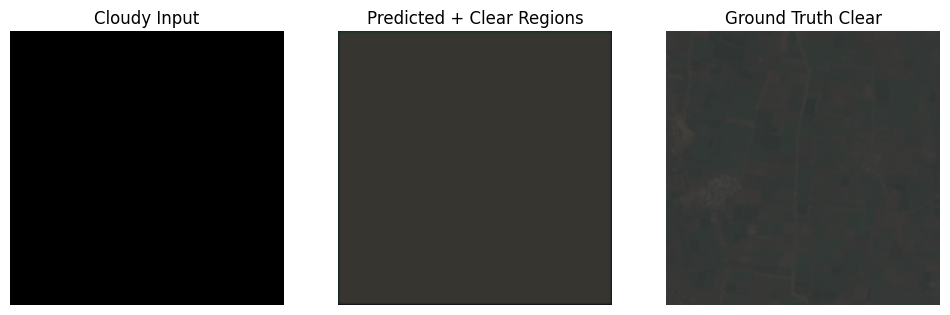

In [ ]:
# =========================
# 7️⃣ Visualization for U-Net
# =========================
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Get a batch from your DataLoader
x_batch, y_batch, mask_batch = next(iter(loader))
x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)

# If mask is single-channel, expand to 3 channels for RGB visualization
if mask_batch.shape[1] == 1:
    mask_batch = mask_batch.repeat(1, 3, 1, 1)

# Forward pass through U-Net
with torch.no_grad():
    pred = model(x_batch)

# Blend prediction with original clear regions using mask
pred_full = pred * mask_batch + x_batch * (1 - mask_batch)

# 🔹 Visualize the first sample in the batch
plt.figure(figsize=(12,4))

# Cloudy input
plt.subplot(1,3,1)
plt.title("Cloudy Input")
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.axis('off')

# Model prediction (only cloudy regions replaced)
plt.subplot(1,3,2)
plt.title("Predicted + Clear Regions")
plt.imshow(pred_full[0].cpu().permute(1,2,0))
plt.axis('off')

# Ground truth clear image
plt.subplot(1,3,3)
plt.title("Ground Truth Clear")
plt.imshow(y_batch[0].cpu().permute(1,2,0))
plt.axis('off')

plt.show()
